In [1]:
# Read data from Kafka, where we have exposed 29092. Note that we are looking for 
# the "assessments" topic we created earlier. Load all this into raw_assessments
raw_assessments = spark \
  .read \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:29092") \
  .option("subscribe","assessments") \
  .option("startingOffsets", "earliest") \
  .option("endingOffsets", "latest") \
  .load()

In [2]:
# Cache to reduce cost of data
raw_assessments.cache()

DataFrame[key: binary, value: binary, topic: string, partition: int, offset: bigint, timestamp: timestamp, timestampType: int]

In [3]:
# See the schema of the data
raw_assessments.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [4]:
# Cast the data as strings
assessments = raw_assessments.select(raw_assessments.value.cast('string'))

In [57]:
import json

# Run Lamba Function to Map X to its value
assessmentsMap = assessments.rdd.map(lambda x: x.value)

## Read in the JSON
extracted_assessments = spark.read.json(assessmentsMap)

# We don't want duplicate assingments, so drop all the ones where Keen ID is the same
extracted_assessments = extracted_assessments.dropDuplicates(['keen_id'])

# Create an in-memory table we can work with
extracted_assessments.registerTempTable('extracted_assessments')

In [58]:
# See the true JSON Schema. Note, you can Access inner parts of the JSON such as All Correct 
# by saying sequences.counts.all_correct
extracted_assessments.printSchema()

root
 |-- base_exam_id: string (nullable = true)
 |-- certification: string (nullable = true)
 |-- exam_name: string (nullable = true)
 |-- keen_created_at: string (nullable = true)
 |-- keen_id: string (nullable = true)
 |-- keen_timestamp: string (nullable = true)
 |-- max_attempts: string (nullable = true)
 |-- sequences: struct (nullable = true)
 |    |-- attempt: long (nullable = true)
 |    |-- counts: struct (nullable = true)
 |    |    |-- all_correct: boolean (nullable = true)
 |    |    |-- correct: long (nullable = true)
 |    |    |-- incomplete: long (nullable = true)
 |    |    |-- incorrect: long (nullable = true)
 |    |    |-- submitted: long (nullable = true)
 |    |    |-- total: long (nullable = true)
 |    |    |-- unanswered: long (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- questions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- options: arra

## How many assesstments are in the dataset?

In [53]:
# Start to run SQL commands, just as we would from BigQuery. Note the name of the table is
# extracted_assessment
spark.sql("SELECT COUNT(*) FROM extracted_assessments").show()

+--------+
|count(1)|
+--------+
|    3242|
+--------+



## What's the name of your Kafka topic? How did you come up with that name?

Assesments, because they seem to be tests on certain material with a grade. We can see this if we put the JSON in an online viewer.

## How many people took Learning Git?

In [54]:
# Simple SQL statement with a where clause
spark.sql("SELECT COUNT(*) FROM extracted_assessments where exam_name='Learning Git'").show()

+--------+
|count(1)|
+--------+
|     390|
+--------+



## What are the average grades for each course?

In [59]:
# This is how you start accessing elements within the nested JSON structure
# We first are getting average grade by taking correct/total, saving it as Percentage
grades = spark.sql("select sequences.counts.correct/sequences.counts.total  as Percentage, exam_name from extracted_assessments")

# We then group by the exam type, and get the mean
grades.groupBy('exam_name').mean().show(50)

+--------------------+-------------------+
|           exam_name|    avg(Percentage)|
+--------------------+-------------------+
|Learning Data Mod...|                0.5|
|Networking for Pe...| 0.5555555555555555|
|Introduction to J...| 0.8759493670886073|
|Learning Apache H...|           0.765625|
|Learning Spring P...|              0.625|
|Learning iPython ...|                0.5|
|Introduction to P...| 0.5666666666666664|
|Learning C# Best ...|0.46206896551724147|
|Introduction to A...| 0.5476190476190476|
|A Practical Intro...| 0.5833333333333334|
|I'm a Software Ar...| 0.5333333333333333|
|Introduction to B...| 0.6061643835616438|
|       View Updating|               0.25|
|Mastering Python ...|               0.74|
|Intermediate C# P...| 0.5512820512820513|
|Starting a Grails...|               0.75|
|Introduction to A...| 0.8333333333333334|
|JavaScript Templa...| 0.6785714285714286|
|Being a Better In...|                0.5|
|Learning Apache M...|           0.609375|
|Data Visua

## What is the least common course taken? And the most common?


In [60]:
from pyspark.sql.functions import desc, asc

# Here, just take names of exams
exam_names = spark.sql("select exam_name  from extracted_assessments")

# Again group by, but then sort them
most_popular = exam_names.groupBy('exam_name').count().sort(desc('count'))
least_popular = exam_names.groupBy('exam_name').count().sort(asc('count'))
most_popular.show(5)


+--------------------+-----+
|           exam_name|count|
+--------------------+-----+
|        Learning Git|  390|
|Introduction to P...|  162|
|Introduction to J...|  158|
|Intermediate Pyth...|  156|
|Learning to Progr...|  128|
+--------------------+-----+
only showing top 5 rows



In [11]:
least_popular.show(5)

+--------------------+-----+
|           exam_name|count|
+--------------------+-----+
|Native Web Apps f...|    1|
|Learning to Visua...|    1|
|Nulls, Three-valu...|    1|
|Operating Red Hat...|    1|
|Learning Spring P...|    2|
+--------------------+-----+
only showing top 5 rows



We can see the most popular and least popular courses above, with Web Apps and Learning Git being lowest and highest respectively. As an education provider, one would know where to target their resources towards.

## Bonus Personal Question: For all the tests that were taken over 50 times, how many times was question 0 correct?

In [62]:
# We first see how many times question 0 was answered
question = spark.sql("select count(sequences.questions.user_result[0]) as total_questions,exam_name from extracted_assessments group by exam_name")

# Next, see how many times question 0 was correct
questionCorrect = spark.sql("select count(sequences.questions.user_result[0])as q_correct,exam_name from extracted_assessments where sequences.questions.user_result[0]='correct' group by exam_name")

# Joine the 2 DF on exam Name
joined_df = question.join(questionCorrect, question['exam_name'] == questionCorrect["exam_name"]).select(question["*"], questionCorrect["q_correct"])

# Divide correct by total questions to get a percentage
new_df = joined_df.withColumn("score", joined_df['q_correct']/joined_df['total_questions'])

# Pick the ones that only have been answered over 50 times
new_df = new_df.filter("total_questions > 50")

# Sort by score
new_df = new_df.orderBy("score").sort(desc('score'))
new_df.show()


+---------------+--------------------+---------+------------------+
|total_questions|           exam_name|q_correct|             score|
+---------------+--------------------+---------+------------------+
|            158|Introduction to J...|      138|0.8734177215189873|
|             57|        Learning SQL|       45|0.7894736842105263|
|             51|   Python Epiphanies|       40|0.7843137254901961|
|             85|    Learning Eclipse|       64|0.7529411764705882|
|             79|Beginning Program...|       58|0.7341772151898734|
|             67|Advanced Machine ...|       49|0.7313432835820896|
|            119|Introduction to M...|       83|0.6974789915966386|
|            390|        Learning Git|      266|0.6820512820512821|
|             58|JavaScript: The G...|       39|0.6724137931034483|
|             80|Learning Apache M...|       52|              0.65|
|             73|Introduction to B...|       45|0.6164383561643836|
|             77|       Mastering Git|       46|

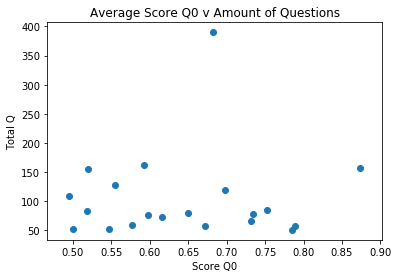

In [17]:
# Convert to Pandas DF
pandas_df = new_df.toPandas()

# Create Graph
import matplotlib.pyplot as plt
plt.scatter(pandas_df['score'], pandas_df['total_questions'])
plt.title("Average Score Q0 v Amount of Questions")
plt.xlabel("Score Q0")
plt.ylabel("Total Q")
plt.show()


## Bonus Personal Question 2: How many Exams were all correct? How many by topic?


In [18]:
spark.sql("select sequences.counts.all_correct, exam_name  from extracted_assessments where sequences.counts.all_correct='true'").count()
#We see it was 827 total, but lets break this out

827

In [23]:
## Find topic with most perfect scores
all_true = spark.sql("select sequences.counts.all_correct, exam_name  from extracted_assessments where sequences.counts.all_correct='true'").groupBy("exam_name").count().sort(desc('count'))

In [34]:
## Now lets find the percentage that are all correct
joined_question2 = question.join(all_true, question['exam_name'] == questionCorrect["exam_name"]).select(question["*"], all_true["count"])

# Divide all correct by total exams
new_df2 = joined_question2.withColumn("score", joined_question2["count"]/joined_question2["total_questions"])

# Order by Score
new_df2 = new_df2.orderBy("score").sort(desc("score"))
new_df2.show(20)


+---------------+--------------------+-----+-------------------+
|total_questions|           exam_name|count|              score|
+---------------+--------------------+-----+-------------------+
|              1|Nulls, Three-valu...|    1|                1.0|
|              2|The Closed World ...|    2|                1.0|
|              1|Learning to Visua...|    1|                1.0|
|             11|Learning SQL for ...|   10| 0.9090909090909091|
|             28|Git Fundamentals ...|   21|               0.75|
|              8|Introduction to H...|    6|               0.75|
|              6|Introduction to A...|    4| 0.6666666666666666|
|            158|Introduction to J...|   94| 0.5949367088607594|
|              7|Introduction to A...|    4| 0.5714285714285714|
|             17|Refactor a Monoli...|    9| 0.5294117647058824|
|              2|What's New in Jav...|    1|                0.5|
|             12|Learning Apache C...|    6|                0.5|
|              9|Introduc

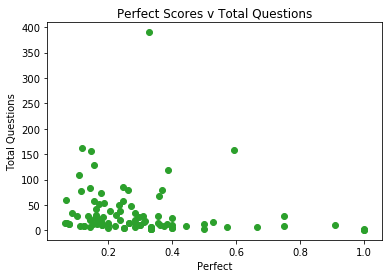

In [43]:
#Convert to DF
pandas_df2 = new_df2.toPandas()

# Graph it
plt.scatter(pandas_df2['score'], pandas_df2['total_questions'])
plt.title("Perfect Scores v Total Questions")
plt.xlabel("Perfect")
plt.ylabel("Total Questions")
plt.show()


## Write to HDFS

This allows the data to be stored on the cloud

In [42]:
new_df.write.parquet("/tmp/df")
new_df2.write.parquet("/tmp/df2")
## You can make sure this goes through in HDFS as well by doing docker-compose exec cloudera hadoop fs -ls /tmp/
